<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl, seaborn as sns
from matplotlib import animation, rc
from IPython.display import HTML
import behalf
import os
from glob import glob
%matplotlib inline

In [237]:
sns.set_context('poster')
rc('animation', html='jshtml')

In [263]:
all_runs = [indir.split('/')[-1] for indir in glob('../results/*')]
all_runs

['mpi_32_1000_1000_10',
 'gpu_64-2_1000_100_100',
 'gpu_8-4_100000_3_100',
 'gpu_384-8_10000_10_100',
 'gpu_8-4_1000_100_100',
 'gpu_4-2_10000_10_100',
 'mpi_16_1000_1000_10',
 'gpu_test',
 'gpu_24-12_1000_100_100',
 'gpu_24-12_100000_3_100',
 'mpi_32_1000_1000_10_old',
 'gpu_8_1000_100_100',
 'gpu_16-8_100000_3_100',
 'gpu_16-8_1000_100_100',
 'gpu_1_4000_30_100',
 'gpu_24-12_10000_10_100',
 'baseline_test',
 'serial_1000_1000_10',
 'serial_1000_1000_100',
 'gpu_8-8_1000_100_100',
 'gpu_2_1000_100_100',
 'gpu_16-8_10000_10_100',
 'gpu_4-4_1000_100_100',
 'gpu_2-2_1000_100_100',
 'gpu_96-2_1000_100_100',
 'gpu_8-4_10000_10_100',
 'gpu_384-8_1000_100_100',
 'gpu_4_1000_100_100',
 'serial_4000_1000_10',
 'gpu_4-2_1000_100_100',
 'serial_16000_1000_10',
 'mpi_8_1000_1000_10',
 'gpu_48_1000_100_100',
 'gpu_1_1000_100_100',
 'mpi_64_1000_1000_10_old',
 'gpu_12-12_1000_100_100',
 'gpu_576-12_10000_10_100',
 'mpi_32_100000_10000_100',
 'gpu_16_1000_100_100',
 'mpi_64_1000_1000_10',
 'gpu_576-

In [264]:
def parse_name(run_name):
    run_type, cores, parts, steps, time = run_name.split('_')
    if len(cores.split('-')) == 2:
        cores, nodes = cores.split('-')
    else:
        nodes = '1'
    dt = float('{:.3f}'.format(1./float(time))) # round to 3 sig figs
    cores = int(cores)
    nodes = int(nodes)
    if 'gpu' not in run_name:
        ngpu = 0
    elif cores > nodes:
        ngpu = 2 * nodes
    else:
        ngpu = 1 * nodes
    parts = int(parts)
    steps = int(steps)
    return cores, nodes, ngpu, parts, steps, dt

In [265]:
class RunResults:
    
    def __init__(self, run_name):
        self.run_name = run_name
        path = '../results/' + run_name + '/'
        self.Ncores, self.Nnodes, self.Ngpu, self.Nparts, self.Nsteps, self.dt = parse_name(run_name)
        with open(path + 'overview.txt', 'r') as f:
            lines = f.readlines()
            lines = [l.rstrip('\n').split(': ')[-1].split(' ')[0] for l in lines]
        self.Mass = float(lines[3])
        self.a = float(lines[4])
        self.theta = float(lines[5])
        self.softening = float(lines[8])
        self.rand_seed = int(lines[9])
        assert(self.Ncores == int(lines[1]))
        assert(self.Nparts == int(lines[2]))
        assert(self.Nsteps == int(lines[7]))
        assert(self.dt == float(lines[6]))
        
        steps = []
        for infile in glob( os.path.join(path, '*.dat') ):
            steps.append(int(infile.split('/')[-1].lstrip('step_').strip('.dat')))
        self.steps = sorted(steps)
        self.time_elapsed = np.array(self.steps) * self.dt
        pos, vel = [],[]
        K, U, E = [], [], []
        times = {'Force': [], 'Gather': [], 'Overall': [], 'Scatter': [], 'Integ.': [], 'Broadcast': [],
                 'Tree': [], 'Comm.': []}
        for i in self.steps:
            infile = path + 'step_{:d}.dat'.format(i)
            data = np.loadtxt(infile)
            pos.append(data[:,:3])
            vel.append(data[:,3:])
            with open(infile, 'r') as f:
                lines = []
                for _ in range(30):
                    l = f.readline()
                    if l.startswith('# '):
                        lines.append(l.lstrip('# ').rstrip('\n').split(':')[-1].lstrip(' \t'))
                    else:
                        break
                K.append(float(lines[2]))
                U.append(float(lines[3]))
                E.append(float(lines[1]))
                times['Force'].append(float(lines[8]))
                times['Gather'].append(float(lines[10]))
                times['Overall'].append(float(lines[12]))
                times['Scatter'].append(float(lines[14]))
                times['Integ.'].append(float(lines[16]))
                times['Broadcast'].append(float(lines[18]))
                times['Tree'].append(float(lines[20]))
                times['Comm.'].append(times['Gather'][-1] + times['Scatter'][-1] + times['Broadcast'][-1])
        self.times = times
        self.med_times = {}
        for k, v in self.times.items():
            self.med_times[k] = np.median(v)
        self.K = np.array(K)
        self.U = np.array(U)
        self.E = np.array(E)
        self.pos = np.array(pos)
        self.vel = np.array(vel)
        
    def plot_energy(self, ax=None, color='k'):
        if ax is None:
            fig, ax = plt.subplots()
            ax.set_xlabel('Time Elapsed (Myr)')
            ax.set_ylabel('Energy (arb. units)')
        ax.plot(self.time_elapsed, self.K, ls=':', color=color)
        ax.plot(self.time_elapsed, self.U, ls='--', color=color)
        ax.plot(self.time_elapsed, self.E, ls='-', color=color, label=self.run_name)
        ax.legend(loc=0)
        return ax
    
    def plot_speedups(self, other, ax=None, color=None, marker=None):
        labels = ['Overall', 'Tree', 'Force', 'Integ.', 'Comm.']
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 6))
            self.colors = sns.color_palette('Set2', 8)[::-1]
            self.markers = ['8','p','D','h','s', '*','^','o']
            ax.set_xlabel('Code Portion')
            ax.set_xticks(np.arange(5))
            ax.set_xticklabels(labels)
            ax.set_ylabel('Speed-Up (x)')
            ax.set_yscale('log')
            title = '{:d} Parts, {:d} Cores, {:d} Nodes, {:d} GPUs'.format(self.Nparts, self.Ncores, self.Nnodes, self.Ngpu)
            ax.set_title('Baseline: {:s}'.format(title))
            ax.axhline(y=1, ls=':')
        if color is None:
            try:
                color = self.colors.pop()
            except IndexError:
                color = 'r'
        if marker is None:
            try:
                marker = self.markers.pop()
            except IndexError:
                marker = 'o'
        for i, k in enumerate(labels):
            label = None
            if i == 0:
                label = ''
                if other.Nparts != self.Nparts:
                    label += '{:d} Parts, '.format(other.Nparts)
                if other.Ncores != self.Ncores:
                    label += '{:d} Cores, '.format(other.Ncores)
                if other.Nnodes != self.Nnodes:
                    label += '{:d} Nodes, '.format(other.Nnodes)
                if other.Ngpu != self.Ngpu:
                    label += '{:d} GPUs'.format(other.Ngpu)
            speedup = self.med_times[k] / other.med_times[k]
            ax.plot(i, speedup, ls='', marker=marker, color=color, label=label)
        ax.legend(loc=0, frameon=True, fontsize='x-small')
        return ax

In [266]:
all_results = {}
for run in all_runs:
    try:
        all_results[run] = RunResults(run)
    except BaseException as e:
        print('X - {:s}'.format(run))
        print(e)
        pass
    else:
        print(run)

X - mpi_32_1000_1000_10
[Errno 2] No such file or directory: '../results/mpi_32_1000_1000_10/overview.txt'
gpu_64-2_1000_100_100
gpu_8-4_100000_3_100
gpu_384-8_10000_10_100
gpu_8-4_1000_100_100
gpu_4-2_10000_10_100
X - mpi_16_1000_1000_10
[Errno 2] No such file or directory: '../results/mpi_16_1000_1000_10/overview.txt'
X - gpu_test
not enough values to unpack (expected 5, got 2)
gpu_24-12_1000_100_100
gpu_24-12_100000_3_100
X - mpi_32_1000_1000_10_old
too many values to unpack (expected 5)
gpu_8_1000_100_100
gpu_16-8_100000_3_100
gpu_16-8_1000_100_100
gpu_1_4000_30_100
gpu_24-12_10000_10_100
X - baseline_test
not enough values to unpack (expected 5, got 2)
X - serial_1000_1000_10
not enough values to unpack (expected 5, got 4)
X - serial_1000_1000_100
not enough values to unpack (expected 5, got 4)
gpu_8-8_1000_100_100
gpu_2_1000_100_100
gpu_16-8_10000_10_100
gpu_4-4_1000_100_100
gpu_2-2_1000_100_100
gpu_96-2_1000_100_100
gpu_8-4_10000_10_100
gpu_384-8_1000_100_100
gpu_4_1000_100_100


In [267]:
for k in sorted(all_results.keys()):
    print(k)

gpu_12-12_1000_100_100
gpu_16-8_100000_3_100
gpu_16-8_10000_10_100
gpu_16-8_1000_100_100
gpu_16_1000_100_100
gpu_1_1000_100_100
gpu_1_16000_10_100
gpu_1_4000_30_100
gpu_2-2_1000_100_100
gpu_24-12_100000_3_100
gpu_24-12_10000_10_100
gpu_24-12_1000_100_100
gpu_2_1000_100_100
gpu_32_1000_100_100
gpu_384-8_10000_10_100
gpu_384-8_1000_100_100
gpu_4-2_10000_10_100
gpu_4-2_1000_100_100
gpu_4-4_1000_100_100
gpu_48_1000_100_100
gpu_4_1000_100_100
gpu_576-12_10000_10_100
gpu_576-12_1000_100_100
gpu_64-2_1000_100_100
gpu_8-4_100000_3_100
gpu_8-4_10000_10_100
gpu_8-4_1000_100_100
gpu_8-8_1000_100_100
gpu_8_1000_100_100
gpu_96-2_1000_100_100


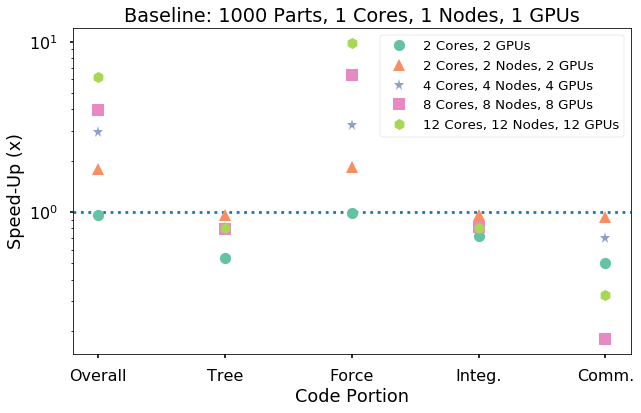

In [251]:
r0 = all_results['gpu_1_1000_100_100']
ax = r0.plot_speedups(all_results['gpu_2_1000_100_100'])
_ = r0.plot_speedups(all_results['gpu_2-2_1000_100_100'], ax=ax)
_ = r0.plot_speedups(all_results['gpu_4-4_1000_100_100'], ax=ax)
_ = r0.plot_speedups(all_results['gpu_8-8_1000_100_100'], ax=ax)
_ = r0.plot_speedups(all_results['gpu_12-12_1000_100_100'], ax=ax)

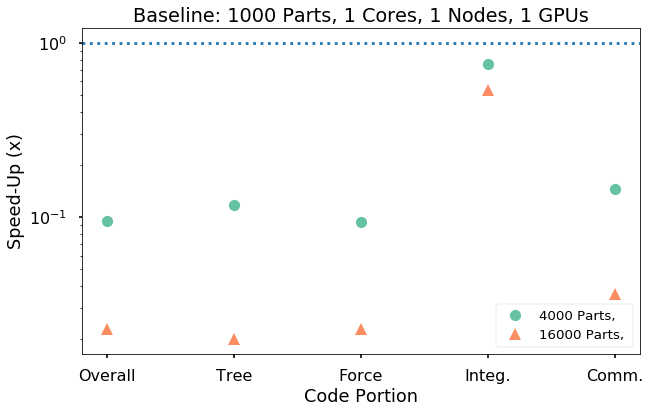

In [252]:
r0 = all_results['gpu_1_1000_100_100']
ax = r0.plot_speedups(all_results['gpu_1_4000_30_100'])
_ = r0.plot_speedups(all_results['gpu_1_16000_10_100'], ax=ax)

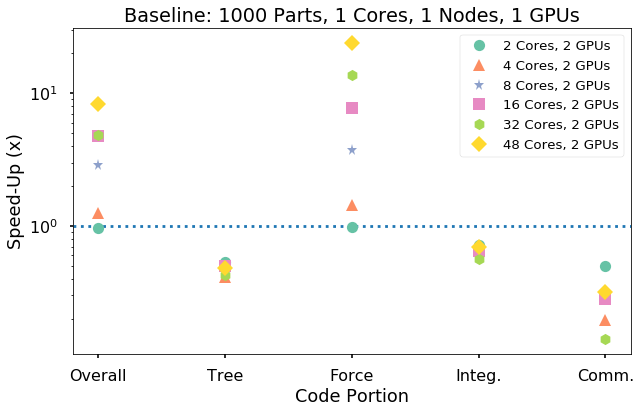

In [253]:
r0 = all_results['gpu_1_1000_100_100']
ax = r0.plot_speedups(all_results['gpu_2_1000_100_100'])
_ = r0.plot_speedups(all_results['gpu_4_1000_100_100'], ax=ax)
_ = r0.plot_speedups(all_results['gpu_8_1000_100_100'], ax=ax)
_ = r0.plot_speedups(all_results['gpu_16_1000_100_100'], ax=ax)
_ = r0.plot_speedups(all_results['gpu_32_1000_100_100'], ax=ax)
_ = r0.plot_speedups(all_results['gpu_48_1000_100_100'], ax=ax)

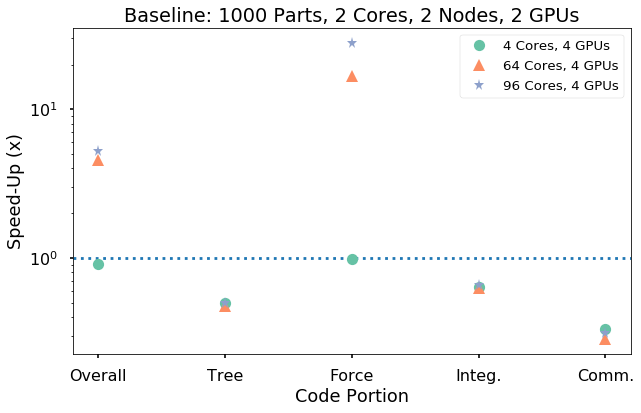

In [254]:
r0 = all_results['gpu_2-2_1000_100_100']
ax = r0.plot_speedups(all_results['gpu_4-2_1000_100_100'])
_ = r0.plot_speedups(all_results['gpu_64-2_1000_100_100'], ax=ax)
_ = r0.plot_speedups(all_results['gpu_96-2_1000_100_100'], ax=ax)

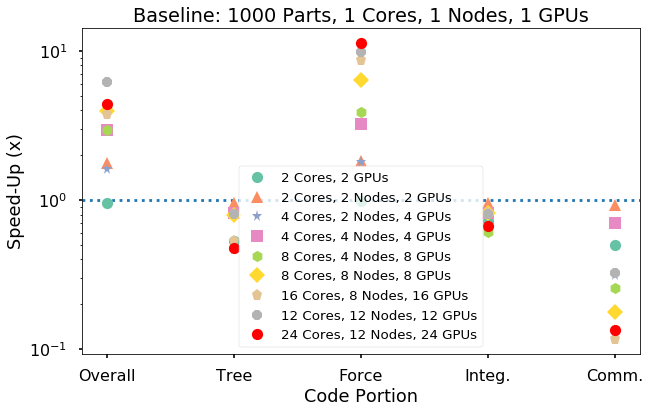

In [255]:
r0 = all_results['gpu_1_1000_100_100']
ax = r0.plot_speedups(all_results['gpu_2_1000_100_100'])
_ = r0.plot_speedups(all_results['gpu_2-2_1000_100_100'], ax=ax)
_ = r0.plot_speedups(all_results['gpu_4-2_1000_100_100'], ax=ax)
_ = r0.plot_speedups(all_results['gpu_4-4_1000_100_100'], ax=ax)
_ = r0.plot_speedups(all_results['gpu_8-4_1000_100_100'], ax=ax)
_ = r0.plot_speedups(all_results['gpu_8-8_1000_100_100'], ax=ax)
_ = r0.plot_speedups(all_results['gpu_16-8_1000_100_100'], ax=ax)
_ = r0.plot_speedups(all_results['gpu_12-12_1000_100_100'], ax=ax)
_ = r0.plot_speedups(all_results['gpu_24-12_1000_100_100'], ax=ax)

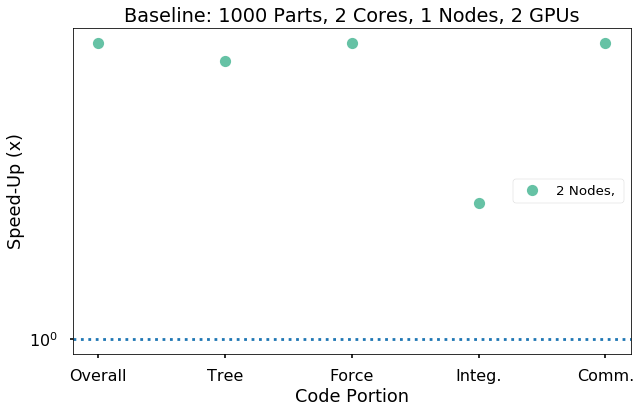

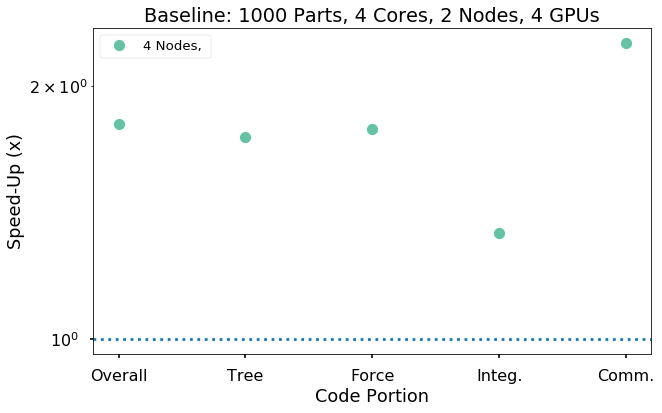

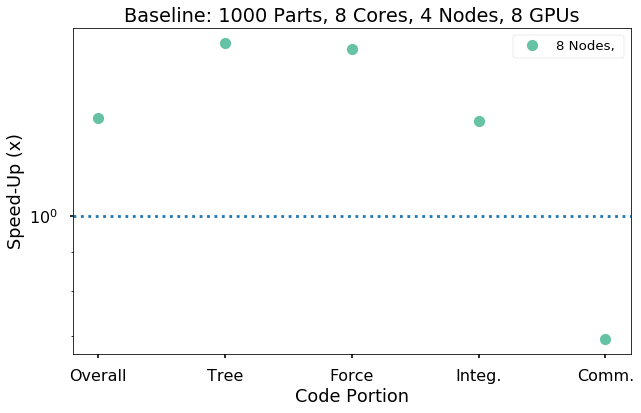

In [270]:
r0 = all_results['gpu_2_1000_100_100']
ax = r0.plot_speedups(all_results['gpu_2-2_1000_100_100'])
r0 = all_results['gpu_4-2_1000_100_100']
ax = r0.plot_speedups(all_results['gpu_4-4_1000_100_100'])
r0 = all_results['gpu_8-4_1000_100_100']
ax = r0.plot_speedups(all_results['gpu_8-8_1000_100_100'])

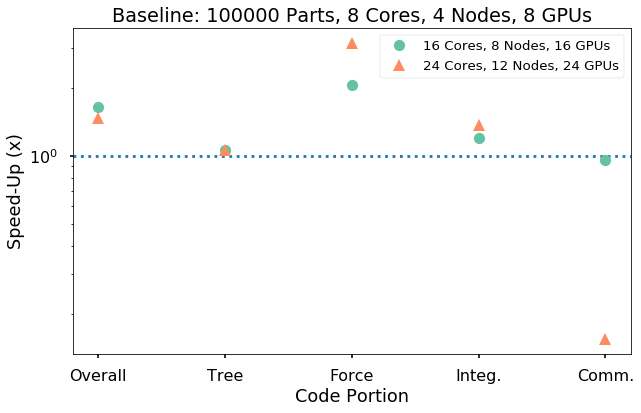

In [256]:
r0 = all_results['gpu_8-4_100000_3_100']
ax = r0.plot_speedups(all_results['gpu_16-8_100000_3_100'])
_ = r0.plot_speedups(all_results['gpu_24-12_100000_3_100'], ax=ax)

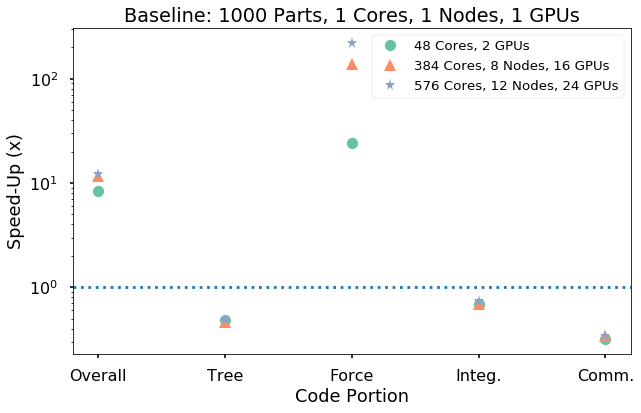

In [268]:
r0 = all_results['gpu_1_1000_100_100']
ax = r0.plot_speedups(all_results['gpu_48_1000_100_100'])
_ = r0.plot_speedups(all_results['gpu_384-8_1000_100_100'], ax=ax)
_ = r0.plot_speedups(all_results['gpu_576-12_1000_100_100'], ax=ax)

In [262]:
all_results['gpu_1_1000_100_100'].med_times

{'Broadcast': 0.38113,
 'Comm.': 0.382386,
 'Force': 27.287326,
 'Gather': 5.6e-05,
 'Integ.': 0.001493,
 'Overall': 28.230558,
 'Scatter': 0.001201,
 'Tree': 0.507885}

In [258]:
all_results['gpu_16-8_100000_3_100'].times

{'Broadcast': [82.345935, 82.176935, 84.49789],
 'Comm.': [99.067568, 100.08633, 96.735434],
 'Force': [954.441, 956.811078, 959.250842],
 'Gather': [16.595181, 17.774613, 12.102179],
 'Integ.': [0.002683, 0.002543, 0.002531],
 'Overall': [1627.936315, 1631.477613, 1633.762294],
 'Scatter': [0.126452, 0.134782, 0.135365],
 'Tree': [573.015699, 573.063134, 576.317867]}

In [28]:
def load_data(run_name, steps=None):
    path = '../results/' + run_name + '/'
    
    pos, vel = [], []
    if steps is None:
        #get all steps
        steps = []
        for infile in glob( os.path.join(path, '*.dat') ):
            steps.append(int(infile.split('/')[-1].lstrip('step_').strip('.dat')))
    steps = sorted(steps)
    for i in steps:
        infile = path + 'step_{:d}.dat'.format(i)
        data = np.loadtxt(infile, unpack=True)
        pos.append(data[:3].T)
        vel.append(data[3:].T)
    return np.array(pos), np.array(vel)

In [33]:
def get_energy(run_name, steps=None, G=4.483e-3, M_total=1e5):
    """
    Returns an array of K, U, E for each timestep in results/run_name/
    Must input number of particles by hand (TO IMPROVE)
    """
    pos, vel = load_data(run_name, steps=steps)
    K, U, E = [], [],[]
    N_p = pos.shape[1]
    for i in range(pos.shape[0]):
        K.append(behalf.utils.compute_kinetic_energy(vel[i], mass=M_total/N_p))
        U.append(behalf.utils.compute_potential_energy(pos[i], mass=M_total/N_p, G=G))
        E.append(K[-1] + U[-1])
    return np.array(K), np.array(U), np.array(E)

In [32]:
def plot_energy(run_name, steps=None, ax=None, M_total=1e5):
    """
    plots K (dotted), U (dashed), and E (solid) for each timestep in results/run_name/
    Must input number of particles by hand (TO IMPROVE)
    """
    if ax is None:
        fig, ax = plt.subplots()
    K, U, E = get_energy(run_name, steps=steps, M_total=M_total)
    ax.plot(K, ls=':', label=run_name)
    ax.plot(U, ls='--', label=run_name)
    ax.plot(E, ls='-', label=run_name)
    return ax

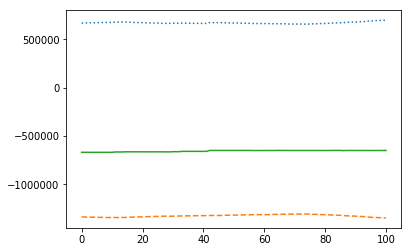

In [34]:
plot_energy('serial_1000_1000_100')

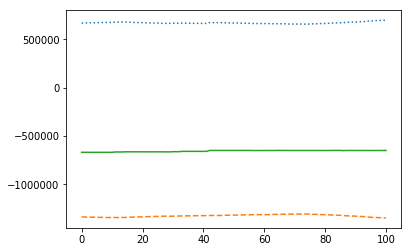

In [35]:
plot_energy('serial_1000_1000_100')

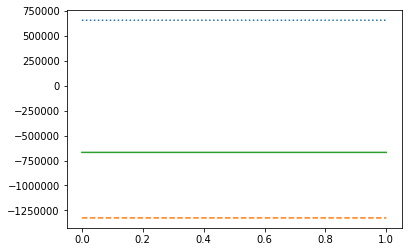

In [36]:
plot_energy('mpi_32_100000_10000_100')

In [18]:
def make_animation(run_name, steps=None, lims=[-200, 200], tstep=200):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    line, = ax.plot([], [], 'ko', ms=5)
    x, y = [], []
    path = '../results/'+run_name+'/'
    if steps is None:
        #get all steps
        steps = []
        for infile in glob( os.path.join(path, '*.dat') ):
            steps.append(int(infile.split('/')[-1].lstrip('step_').strip('.dat')))
    steps = sorted(steps)
    for i in steps:
        infile = path + 'step_{:d}.dat'.format(i)
        data = np.loadtxt(infile, unpack=True)
        x.append(data[0])
        y.append(data[1])
    x = np.array(x)
    y = np.array(y)
    
    def init():
        line.set_data([], [])
        return (line,)

    def animate(i):
        x_ = x[i]
        y_ = y[i]
        line.set_data(x_, y_)
        return (line,)
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=range(len(x)), interval=tstep, 
                               blit=True)
    return anim, x, y

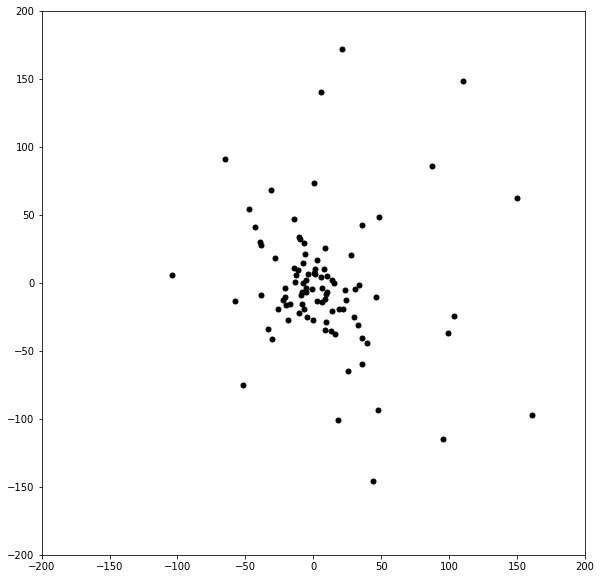

In [19]:
anim, x, y = make_animation('gpu_test')
anim